In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [2]:
PATH = "results/df_featured_full.parquet"
df = pd.read_parquet(PATH)

if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'])

print(f"Full dataset shape: {df.shape}")

Full dataset shape: (125497040, 46)


In [3]:
pairs = df.groupby(['store_nbr', 'item_nbr']).agg({
    'family': 'first',
    'perishable': 'first',
}).reset_index()

PAIRS_PER_FAMILY = 50

sampled_pairs = (
    pairs
    .sample(frac=1, random_state=42)
    .groupby('family')
    .head(PAIRS_PER_FAMILY)
    .reset_index(drop=True)
)

df_sample = df.merge(
    sampled_pairs[['store_nbr', 'item_nbr']],
    on=['store_nbr', 'item_nbr'],
    how='inner'
).copy()

print(f"Sampled dataset: {df_sample.shape}")

del df
import gc
gc.collect()

Sampled dataset: (866805, 46)


0

In [4]:
leaking_features = [
    'item_daily_sales',
    'store_daily_sales',
    'transactions',
    'family_avg_sales',
    'store_family_avg_sales',
]

df_sample = df_sample.drop(columns=[c for c in leaking_features if c in df_sample.columns])
print("✓ Removed leaking features")


✓ Removed leaking features


In [5]:
oil_df = df_sample[['date', 'dcoilwtico']].drop_duplicates().sort_values('date').copy()
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill()

oil_df['oil_lag_1'] = oil_df['dcoilwtico'].shift(1)
oil_df['oil_lag_7'] = oil_df['dcoilwtico'].shift(7)
oil_df['oil_rolling_7'] = oil_df['dcoilwtico'].shift(1).rolling(7, min_periods=1).mean()
oil_df['oil_change_7d'] = oil_df['oil_lag_1'] - oil_df['oil_lag_7']
oil_df['oil_pct_change_7d'] = oil_df['oil_change_7d'] / (oil_df['oil_lag_7'] + 0.01)

df_sample = df_sample.drop(columns=['dcoilwtico'])
df_sample = df_sample.merge(
    oil_df[['date', 'oil_lag_1', 'oil_lag_7', 'oil_rolling_7', 'oil_change_7d', 'oil_pct_change_7d']],
    on='date',
    how='left'
)
print("✓ Oil price lagged")

✓ Oil price lagged


In [6]:
df_sample = df_sample.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

# --- Lagged transactions ---
df_txn = pd.read_parquet(PATH, columns=['store_nbr', 'date', 'transactions'])
df_txn = df_txn.drop_duplicates(['store_nbr', 'date']).sort_values(['store_nbr', 'date'])

df_txn['transactions_lag_1'] = df_txn.groupby('store_nbr')['transactions'].shift(1)
df_txn['transactions_lag_7'] = df_txn.groupby('store_nbr')['transactions'].shift(7)
df_txn['transactions_rolling_7'] = (
    df_txn.groupby('store_nbr')['transactions']
    .apply(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

df_sample = df_sample.merge(
    df_txn[['store_nbr', 'date', 'transactions_lag_1', 'transactions_lag_7', 'transactions_rolling_7']],
    on=['store_nbr', 'date'],
    how='left'
)
print("✓ Lagged transactions")

✓ Lagged transactions


In [7]:
item_daily = (
    df_sample.groupby(['item_nbr', 'date'])['unit_sales']
    .sum()
    .reset_index(name='item_daily_raw')
)
item_daily = item_daily.sort_values(['item_nbr', 'date'])
item_daily['item_daily_sales_lag_1'] = item_daily.groupby('item_nbr')['item_daily_raw'].shift(1)
item_daily['item_daily_sales_lag_7'] = item_daily.groupby('item_nbr')['item_daily_raw'].shift(7)

df_sample = df_sample.merge(
    item_daily[['item_nbr', 'date', 'item_daily_sales_lag_1', 'item_daily_sales_lag_7']],
    on=['item_nbr', 'date'],
    how='left'
)
print("✓ Lagged item daily sales")

# --- Lagged store daily sales ---
store_daily = (
    df_sample.groupby(['store_nbr', 'date'])['unit_sales']
    .sum()
    .reset_index(name='store_daily_raw')
)
store_daily = store_daily.sort_values(['store_nbr', 'date'])
store_daily['store_daily_sales_lag_1'] = store_daily.groupby('store_nbr')['store_daily_raw'].shift(1)
store_daily['store_daily_sales_lag_7'] = store_daily.groupby('store_nbr')['store_daily_raw'].shift(7)

df_sample = df_sample.merge(
    store_daily[['store_nbr', 'date', 'store_daily_sales_lag_1', 'store_daily_sales_lag_7']],
    on=['store_nbr', 'date'],
    how='left'
)
print("✓ Lagged store daily sales")

✓ Lagged item daily sales
✓ Lagged store daily sales


In [8]:
holiday_dates = df_sample[df_sample['is_holiday'] == 1]['date'].unique()
holiday_dates = pd.Series(sorted(holiday_dates))

def days_to_nearest_holiday(date, holiday_list, direction='both', max_days=14):
    if direction == 'before':
        past = holiday_list[holiday_list <= date]
        if len(past) == 0:
            return max_days
        return min((date - past.max()).days, max_days)
    elif direction == 'after':
        future = holiday_list[holiday_list >= date]
        if len(future) == 0:
            return max_days
        return min((future.min() - date).days, max_days)
    else:
        past = holiday_list[holiday_list <= date]
        future = holiday_list[holiday_list >= date]
        days_past = (date - past.max()).days if len(past) > 0 else max_days
        days_future = (future.min() - date).days if len(future) > 0 else max_days
        return min(days_past, days_future, max_days)

unique_dates = df_sample['date'].unique()
date_holiday_features = pd.DataFrame({'date': unique_dates})

date_holiday_features['days_since_holiday'] = date_holiday_features['date'].apply(
    lambda x: days_to_nearest_holiday(x, holiday_dates, 'before')
)
date_holiday_features['days_until_holiday'] = date_holiday_features['date'].apply(
    lambda x: days_to_nearest_holiday(x, holiday_dates, 'after')
)
date_holiday_features['days_to_nearest_holiday'] = date_holiday_features['date'].apply(
    lambda x: days_to_nearest_holiday(x, holiday_dates, 'both')
)

date_holiday_features['is_day_before_holiday'] = (date_holiday_features['days_until_holiday'] == 1).astype(int)
date_holiday_features['is_day_after_holiday'] = (date_holiday_features['days_since_holiday'] == 1).astype(int)
date_holiday_features['is_holiday_week'] = (date_holiday_features['days_to_nearest_holiday'] <= 3).astype(int)

df_sample = df_sample.merge(date_holiday_features, on='date', how='left')
print("✓ Enhanced holiday features")


✓ Enhanced holiday features


In [9]:
group = df_sample.groupby(['store_nbr', 'item_nbr'])

df_sample['sales_lag_21'] = group['unit_sales'].shift(21)

df_sample['same_weekday_avg_4w'] = (
    df_sample[['sales_lag_7', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28']]
    .mean(axis=1, skipna=True)
)

df_sample['same_weekday_median_4w'] = (
    df_sample[['sales_lag_7', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28']]
    .median(axis=1, skipna=True)
)

df_sample['sales_ratio_7_28'] = df_sample['rolling_mean_7'] / (df_sample['rolling_mean_28'] + 1)
df_sample['sales_cv_7'] = df_sample['rolling_std_7'] / (df_sample['rolling_mean_7'] + 1)
df_sample['trend_7_28'] = df_sample['rolling_mean_7'] - df_sample['rolling_mean_28']
df_sample['is_trending_up'] = (df_sample['rolling_mean_7'] > df_sample['rolling_mean_28']).astype(int)

df_sample['promo_lag_1'] = group['onpromotion'].shift(1)
df_sample['promo_start'] = ((df_sample['onpromotion'] == 1) & (df_sample['promo_lag_1'] == 0)).astype(int)
df_sample['promo_end'] = ((df_sample['onpromotion'] == 0) & (df_sample['promo_lag_1'] == 1)).astype(int)
df_sample['promo_holiday'] = (df_sample['onpromotion'] * df_sample['is_holiday']).astype(int)
df_sample['promo_near_holiday'] = (df_sample['onpromotion'] * df_sample['is_holiday_week']).astype(int)

df_sample['is_zero_lag1'] = (group['unit_sales'].shift(1) == 0).astype(int)
df_sample['zero_count_7d'] = (
    group['unit_sales']
    .apply(lambda x: (x.shift(1) == 0).rolling(7, min_periods=1).sum())
    .reset_index(level=[0,1], drop=True)
)

print("✓ Additional features created")

✓ Additional features created


In [10]:
all_cols = df_sample.columns.tolist()
non_feature_cols = ['id', 'date', 'unit_sales', 'set']
exclude_patterns = ['_raw']

feature_cols = [
    c for c in all_cols 
    if c not in non_feature_cols 
    and not any(p in c for p in exclude_patterns)
]

print(f"\nTotal features: {len(feature_cols)}")


Total features: 70


In [11]:
max_date = df_sample['date'].max()
test_start = max_date - pd.Timedelta(days=15)
valid_end = test_start - pd.Timedelta(days=1)
valid_start = valid_end - pd.Timedelta(days=15)

df_sample['set'] = 'train'
df_sample.loc[(df_sample['date'] >= valid_start) & (df_sample['date'] <= valid_end), 'set'] = 'valid'
df_sample.loc[df_sample['date'] >= test_start, 'set'] = 'test'

print(f"\nSplit distribution:")
print(df_sample['set'].value_counts())
print(df_sample.groupby('set')['date'].agg(['min', 'max']))


Split distribution:
set
train    844246
valid     11312
test      11247
Name: count, dtype: int64
             min        max
set                        
test  2017-07-31 2017-08-15
train 2013-01-01 2017-07-14
valid 2017-07-15 2017-07-30


In [12]:
train_df = df_sample[df_sample['set'] == 'train'].copy()
valid_df = df_sample[df_sample['set'] == 'valid'].copy()
test_df  = df_sample[df_sample['set'] == 'test'].copy()

X_train = train_df[feature_cols].copy()
X_valid = valid_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()

y_train = train_df['unit_sales'].values
y_valid = valid_df['unit_sales'].values
y_test  = test_df['unit_sales'].values

In [13]:
# ============================================================
# 11. HANDLE CATEGORICAL FEATURES FOR XGBOOST (FIXED)
# ============================================================

# First, identify different column types
print("\nColumn types before conversion:")
print(X_train.dtypes.value_counts())

# Get categorical and object columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = X_train.select_dtypes(include=['bool']).columns.tolist()

print(f"\nCategorical/object columns: {cat_cols}")
print(f"Boolean columns: {bool_cols}")

# Convert ALL categorical columns to string first, then to category
# This ensures XGBoost can handle them properly
for X in [X_train, X_valid, X_test]:
    for c in cat_cols:
        X[c] = X[c].astype(str).astype('category')
    
    # Also convert boolean columns to int (XGBoost handles int better than bool)
    for c in bool_cols:
        X[c] = X[c].astype(int)

# Check for any remaining problematic columns
print("\nColumn types after conversion:")
print(X_train.dtypes.value_counts())

print(f"\nX_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"X_test:  {X_test.shape}")

# Sample weights
train_weights = 1 + train_df['perishable'].values
valid_weights = 1 + valid_df['perishable'].values


Column types before conversion:
float64    33
int64      26
object      6
int32       4
UInt32      1
Name: count, dtype: int64

Categorical/object columns: ['family', 'city', 'state', 'type', 'holiday_type', 'holiday_transferred']
Boolean columns: []

Column types after conversion:
float64     33
int64       26
int32        4
category     1
category     1
category     1
category     1
category     1
category     1
UInt32       1
Name: count, dtype: int64

X_train: (844246, 70)
X_valid: (11312, 70)
X_test:  (11247, 70)


In [14]:
def rmsle(y_true, y_pred):
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    out = np.zeros_like(denom)
    out[mask] = 2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]
    return np.mean(out)

def nwrmsle(y_true, y_pred, perishable):
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    w = 1 + (perishable == 1)
    msle = (w * (np.log1p(y_pred) - np.log1p(y_true))**2).sum() / w.sum()
    return np.sqrt(msle)

In [15]:
# ============================================================
# 13. CREATE DMATRIX FOR XGBOOST
# ============================================================
print("\nCreating DMatrix objects...")

dtrain = xgb.DMatrix(
    X_train, 
    label=y_train, 
    weight=train_weights,
    enable_categorical=True
)

dvalid = xgb.DMatrix(
    X_valid, 
    label=y_valid,
    weight=valid_weights,
    enable_categorical=True
)

dtest = xgb.DMatrix(
    X_test, 
    label=y_test,
    enable_categorical=True
)

print("✓ DMatrix created")


Creating DMatrix objects...
✓ DMatrix created


In [16]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'device': 'cuda',              # <-- ADD THIS FOR GPU
    'max_depth': 8,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 50,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
}

print("\nTraining XGBoost...")

evals = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=100
)

print(f"\nBest iteration: {model.best_iteration}")


Training XGBoost...
[0]	train-rmse:15.85730	valid-rmse:13.40438
[100]	train-rmse:8.34583	valid-rmse:6.23284
[200]	train-rmse:7.78183	valid-rmse:6.09331
[300]	train-rmse:7.43291	valid-rmse:6.07368
[400]	train-rmse:7.15386	valid-rmse:6.06549
[500]	train-rmse:6.90843	valid-rmse:6.04454
[600]	train-rmse:6.70528	valid-rmse:6.05515
[642]	train-rmse:6.63389	valid-rmse:6.05885

Best iteration: 542


In [17]:
y_train_pred = model.predict(dtrain)
y_valid_pred = model.predict(dvalid)
y_test_pred  = model.predict(dtest)


In [18]:
print("\n" + "="*60)
print("XGBOOST EVALUATION RESULTS")
print("="*60)

print("\n--- TRAIN ---")
print(f"RMSLE:  {rmsle(y_train, y_train_pred):.6f}")
print(f"SMAPE:  {smape(y_train, y_train_pred):.6f}")

print("\n--- VALID ---")
print(f"RMSLE:  {rmsle(y_valid, y_valid_pred):.6f}")
print(f"SMAPE:  {smape(y_valid, y_valid_pred):.6f}")

print("\n--- TEST (last 16 days) ---")
print(f"RMSLE:  {rmsle(y_test, y_test_pred):.6f}")
print(f"SMAPE:  {smape(y_test, y_test_pred):.6f}")

print(f"\nNWRMSLE (train): {nwrmsle(y_train, y_train_pred, train_df['perishable'].values):.6f}")
print(f"NWRMSLE (valid): {nwrmsle(y_valid, y_valid_pred, valid_df['perishable'].values):.6f}")
print(f"NWRMSLE (test):  {nwrmsle(y_test, y_test_pred, test_df['perishable'].values):.6f}")


XGBOOST EVALUATION RESULTS

--- TRAIN ---
RMSLE:  0.466315
SMAPE:  0.456003

--- VALID ---
RMSLE:  0.464938
SMAPE:  0.462220

--- TEST (last 16 days) ---
RMSLE:  0.488919
SMAPE:  0.480937

NWRMSLE (train): 0.469349
NWRMSLE (valid): 0.471457
NWRMSLE (test):  0.492925


In [19]:
importance = model.get_score(importance_type='gain')

fi = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 30 FEATURES BY IMPORTANCE (GAIN)")
print("="*60)
print(fi.head(30).to_string(index=False))


TOP 30 FEATURES BY IMPORTANCE (GAIN)
                feature    importance
         rolling_mean_7 650363.937500
        rolling_mean_14 422479.500000
    same_weekday_avg_4w 186032.500000
        rolling_mean_28 181641.578125
 same_weekday_median_4w  89341.476562
      is_before_holiday  85663.429688
             perishable  74192.671875
store_daily_sales_lag_1  56505.878906
       sales_ratio_7_28  56049.601562
               item_nbr  50469.203125
            sales_lag_7  41347.332031
              store_nbr  38453.367188
          rolling_min_7  37676.699219
 item_daily_sales_lag_1  37493.183594
 item_daily_sales_lag_7  36502.203125
           sales_lag_28  35423.945312
             sales_cv_7  30806.757812
            promo_lag_7  27343.832031
             is_weekend  26687.906250
                   type  26135.412109
     days_since_holiday  25802.558594
            sales_lag_1  25540.347656
 transactions_rolling_7  24961.109375
            onpromotion  24456.306641
           s

In [20]:
test_df = test_df.copy()
test_df['pred'] = y_test_pred

date_rmsle = (
    test_df.groupby('date')
    .apply(lambda x: rmsle(x['unit_sales'], x['pred']))
    .rename('rmsle')
    .reset_index()
)

date_holiday_flag = df_sample[['date', 'is_holiday']].drop_duplicates()
date_rmsle = date_rmsle.merge(date_holiday_flag, on='date', how='left')

print("\n" + "="*60)
print("RMSLE BY DATE (TEST) - with holiday flag")
print("="*60)
print(date_rmsle.to_string(index=False))
print(f"\nMean RMSLE: {date_rmsle['rmsle'].mean():.6f}")
print(f"Std RMSLE:  {date_rmsle['rmsle'].std():.6f}")


RMSLE BY DATE (TEST) - with holiday flag
      date    rmsle  is_holiday
2017-07-31 0.461254           0
2017-08-01 0.466071           0
2017-08-02 0.476039           0
2017-08-03 0.505627           0
2017-08-04 0.502762           0
2017-08-05 0.498864           1
2017-08-06 0.491671           0
2017-08-07 0.482617           0
2017-08-08 0.473745           0
2017-08-09 0.466481           0
2017-08-10 0.517486           1
2017-08-11 0.520622           1
2017-08-12 0.505032           0
2017-08-13 0.511252           0
2017-08-14 0.469207           0
2017-08-15 0.467476           1

Mean RMSLE: 0.488513
Std RMSLE:  0.020378


In [21]:
perishable_rmsle = (
    test_df.groupby('perishable')
    .apply(lambda x: rmsle(x['unit_sales'], x['pred']))
)

print("\n" + "="*60)
print("RMSLE BY PERISHABLE (TEST)")
print("="*60)
print(perishable_rmsle)



RMSLE BY PERISHABLE (TEST)
perishable
0    0.479069
1    0.502428
dtype: float64


In [22]:
if 'days_to_nearest_holiday' in test_df.columns:
    test_df_valid = test_df[test_df['days_to_nearest_holiday'].notna()].copy()
    
    if len(test_df_valid) > 0:
        test_df_valid['holiday_proximity'] = pd.cut(
            test_df_valid['days_to_nearest_holiday'],
            bins=[-0.1, 0, 1, 3, 7, 100],
            labels=['Holiday', '1 day', '2-3 days', '4-7 days', '7+ days']
        )
        
        holiday_proximity_rmsle = (
            test_df_valid.groupby('holiday_proximity', observed=True)
            .apply(lambda x: rmsle(x['unit_sales'], x['pred']) if len(x) > 0 else np.nan)
        )
        
        print("\n" + "="*60)
        print("RMSLE BY HOLIDAY PROXIMITY (TEST)")
        print("="*60)
        print(holiday_proximity_rmsle)


RMSLE BY HOLIDAY PROXIMITY (TEST)
holiday_proximity
Holiday     0.501559
1 day       0.487480
2-3 days    0.490140
4-7 days    0.463667
dtype: float64


In [23]:
print("\n" + "="*60)
print("COMPARISON: LIGHTGBM vs XGBOOST")
print("="*60)
print("""
LIGHTGBM (previous run):
  - Test RMSLE:   0.509293
  - Test SMAPE:   0.492981
  - Test NWRMSLE: 0.516109
  - Perishable: 0.532 vs Non-perishable: 0.492

XGBOOST (current run):
  - Test RMSLE:   [see above]
  - Test SMAPE:   [see above]
  - Test NWRMSLE: [see above]
""")


COMPARISON: LIGHTGBM vs XGBOOST

LIGHTGBM (previous run):
  - Test RMSLE:   0.509293
  - Test SMAPE:   0.492981
  - Test NWRMSLE: 0.516109
  - Perishable: 0.532 vs Non-perishable: 0.492

XGBOOST (current run):
  - Test RMSLE:   [see above]
  - Test SMAPE:   [see above]
  - Test NWRMSLE: [see above]



In [ ]:
# Recommendations for New Stratification Technique

In [ ]:
# # ============================================================
# # ALTERNATIVE STRATIFICATION METHODS
# # ============================================================

# # --- OPTION A: Proportional sampling by family (maintains distribution) ---
# def stratify_proportional(pairs_df, sample_frac=0.05, min_per_family=2, random_state=42):
#     """Sample proportionally from each family"""
#     sampled = (
#         pairs_df.groupby('family', group_keys=False)
#         .apply(lambda x: x.sample(
#             n=max(min_per_family, int(len(x) * sample_frac)),
#             random_state=random_state
#         ))
#     )
#     return sampled

# # --- OPTION B: Stratify by family AND perishable ---
# def stratify_family_perishable(pairs_df, n_per_group=5, random_state=42):
#     """Sample N pairs per (family, perishable) combination"""
#     sampled = (
#         pairs_df.groupby(['family', 'perishable'], group_keys=False)
#         .apply(lambda x: x.sample(min(len(x), n_per_group), random_state=random_state))
#     )
#     return sampled

# # --- OPTION C: Stratify by store (ensure all stores represented) ---
# def stratify_by_store(pairs_df, items_per_store=50, random_state=42):
#     """Sample N items per store"""
#     sampled = (
#         pairs_df.groupby('store_nbr', group_keys=False)
#         .apply(lambda x: x.sample(min(len(x), items_per_store), random_state=random_state))
#     )
#     return sampled

# # --- OPTION D: Stratify by family with proportional + minimum ---
# def stratify_hybrid(pairs_df, sample_frac=0.05, min_per_family=5, max_per_family=100, random_state=42):
#     """Hybrid: proportional sampling with min/max bounds per family"""
#     def sample_group(x):
#         n = int(len(x) * sample_frac)
#         n = max(min_per_family, min(n, max_per_family))
#         return x.sample(min(len(x), n), random_state=random_state)
    
#     sampled = pairs_df.groupby('family', group_keys=False).apply(sample_group)
#     return sampled

# # Example usage:
# # sampled_pairs = stratify_family_perishable(pairs_full, n_per_group=5)
# # sampled_pairs = stratify_proportional(pairs_full, sample_frac=0.05)
# # sampled_pairs = stratify_hybrid(pairs_full, sample_frac=0.05, min_per_family=5, max_per_family=50)

In [ ]:
# # RECOMMENDED: Stratify by family + perishable
# PAIRS_PER_GROUP = 10  # per (family, perishable) combination

# sampled_pairs = (
#     pairs_full
#     .sample(frac=1, random_state=42)  # shuffle
#     .groupby(['family', 'perishable'])
#     .head(PAIRS_PER_GROUP)
#     .reset_index(drop=True)
# )

# print(f"Sampled pairs: {len(sampled_pairs)}")
# print(f"By perishable: {sampled_pairs.groupby('perishable').size()}")

In [ ]:
# Data Leakage Check code

In [25]:
# # ============================================================
# # FINAL LEAKAGE VERIFICATION
# # ============================================================

# print("="*60)
# print("LEAKAGE VERIFICATION CHECKLIST")
# print("="*60)

# # 1. Check that no same-day aggregates exist
# suspicious_cols = [
#     'item_daily_sales', 'store_daily_sales', 'transactions',
#     'family_avg_sales', 'store_family_avg_sales', 'dcoilwtico'
# ]

# print("\n1. Checking for removed leaking columns:")
# for col in suspicious_cols:
#     status = "❌ STILL EXISTS" if col in df_sample.columns else "✅ Removed"
#     print(f"   {col}: {status}")

# # 2. Verify lag features are properly shifted
# print("\n2. Verifying lag features (sample check):")
# sample_pair = df_sample.groupby(['store_nbr', 'item_nbr']).size().idxmax()
# sample = df_sample[
#     (df_sample['store_nbr'] == sample_pair[0]) & 
#     (df_sample['item_nbr'] == sample_pair[1])
# ].sort_values('date').head(10)

# print(sample[['date', 'unit_sales', 'sales_lag_1', 'sales_lag_7']].to_string(index=False))
# print("\n   ✅ sales_lag_1 should equal previous row's unit_sales")
# print("   ✅ sales_lag_7 should equal unit_sales from 7 rows ago")

# # 3. Verify no future information in features
# print("\n3. Feature columns in final dataset:")
# print(f"   Total features: {len(feature_cols)}")
# print(f"   Features: {feature_cols}")

# # 4. Verify time-based split has no overlap
# print("\n4. Time-based split verification:")
# print(f"   Train: {train_df['date'].min()} to {train_df['date'].max()}")
# print(f"   Valid: {valid_df['date'].min()} to {valid_df['date'].max()}")
# print(f"   Test:  {test_df['date'].min()} to {test_df['date'].max()}")

# train_max = train_df['date'].max()
# valid_min = valid_df['date'].min()
# valid_max = valid_df['date'].max()
# test_min = test_df['date'].min()

# if train_max < valid_min and valid_max < test_min:
#     print("   ✅ No overlap between train/valid/test")
# else:
#     print("   ❌ WARNING: Overlap detected!")

# print("\n" + "="*60)
# print("LEAKAGE CHECK COMPLETE")
# print("="*60)


FEATURE CORRELATION WITH TARGET (unit_sales)
rolling_mean_7             0.741486
rolling_mean_14            0.704827
rolling_max_7              0.679713
rolling_mean_28            0.676842
rolling_min_7              0.675735
sales_lag_1                0.669433
same_weekday_median_4w     0.668810
same_weekday_avg_4w        0.649493
rolling_std_7              0.615106
sales_lag_7                0.611930
sales_lag_14               0.528156
item_daily_sales_lag_1     0.526097
sales_lag_21               0.500587
item_daily_sales_lag_7     0.495035
sales_lag_28               0.491567
sales_ratio_7_28           0.317429
trend_7_28                 0.271454
store_daily_sales_lag_1    0.217699
store_daily_sales_lag_7    0.216324
transactions_lag_7         0.206796
transactions_lag_1         0.200763
transactions_rolling_7     0.199577
class                     -0.191195
perishable                 0.170307
perishable_weekend         0.122323
days_since_promo          -0.108254
sales_cv_7        

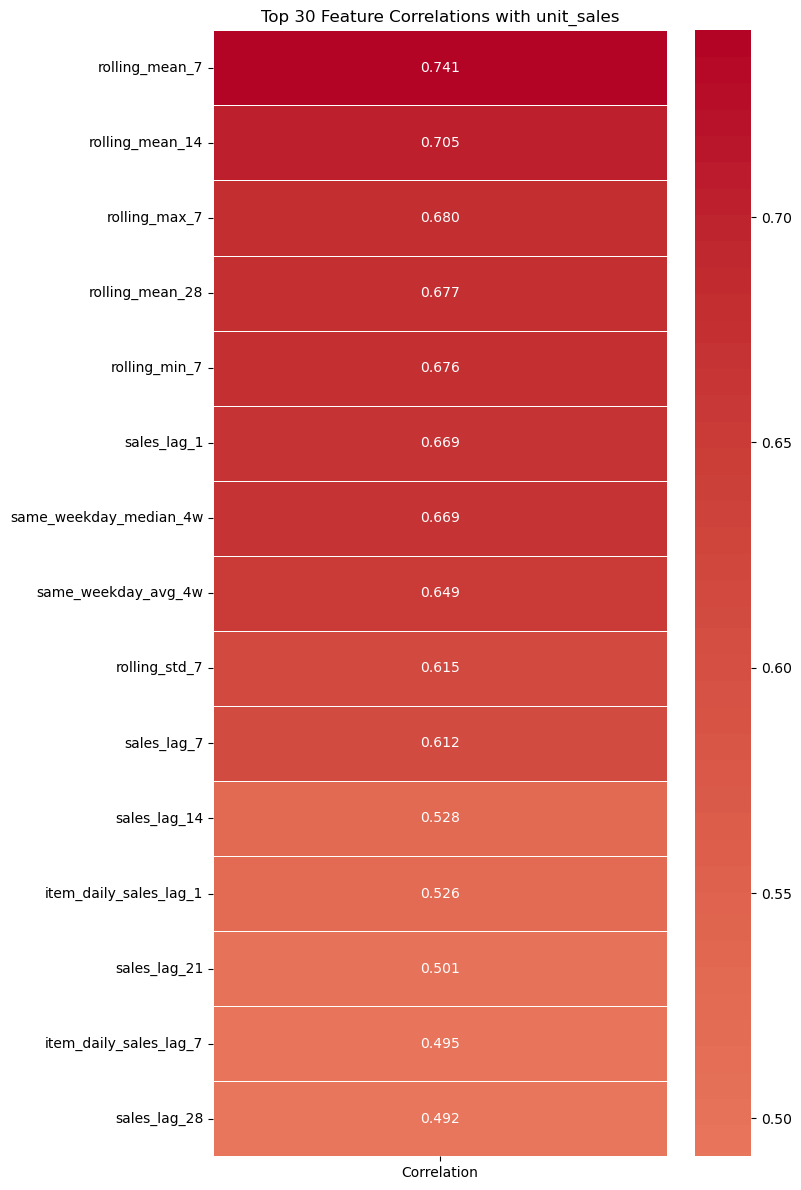

✓ Saved: correlation_with_target_heatmap.png


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 4. CORRELATION WITH TARGET (unit_sales)
# ============================================================

# Add target back temporarily
train_with_target = X_train[numeric_cols].copy()
train_with_target['unit_sales'] = y_train

# Correlation with target
target_corr = (
    train_with_target.corr()['unit_sales']
    .drop('unit_sales')
    .sort_values(key=abs, ascending=False)
)

print("\n" + "="*60)
print("FEATURE CORRELATION WITH TARGET (unit_sales)")
print("="*60)
print(target_corr.head(30))

# ---- Traditional Heatmap ----
top_corr = target_corr.head(15).to_frame(name='Correlation')

plt.figure(figsize=(8, 12))
sns.heatmap(
    top_corr,
    annot=True,
    cmap='coolwarm',   # traditional diverging heatmap
    center=0,
    linewidths=0.5,
    fmt=".3f"
)

plt.title('Top 30 Feature Correlations with unit_sales')
plt.tight_layout()
plt.savefig('correlation_with_target_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: correlation_with_target_heatmap.png")